# This is a test script to showcase utilizing pytorch and deep learning training loops within jupyter notebooks

## This code uses the CIFAR-10 dataset, which is comprised of 32x32 pixel RGB images, and has 10 different classes of images


## Import packages

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Initialize the training/validation/testing datasets

In [10]:
# Set the minibatch size
minibatch_size = 5

# Set the appropriate transform of images (this casts numpy images to torch.tensor images and then normalizes them)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Initialize the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True,transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size,shuffle=True)

# Initialize the validation set
validset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False,transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=minibatch_size, shuffle=False)

# Initialize the testing set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# Identify the appropriate classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Show the first mini-batch 

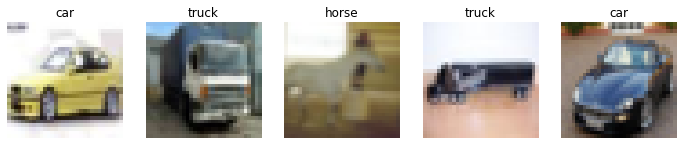

In [15]:
# Load in a minibatch
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(12,8))
for i in range(minibatch_size):
    plt.subplot(1,minibatch_size,i+1)
    plt.axis('off')
    plt.imshow((np.transpose(images[i,:,:,:].detach().numpy(),(1,2,0)) / 2) + 0.5)
    plt.title(classes[labels[i]])

## Generate the deep learning model to be used

In [16]:
# Generate the model that is going to be used
model = nn.Sequential(
          nn.Conv2d(3,6,5),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(6,16,5),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Flatten(),
          nn.Linear(400,120),
          nn.ReLU(),
          nn.Linear(120,84),
          nn.ReLU(),
          nn.Linear(84,10)
        )

# Send CNN model to GPU
model = model.cuda()

# Set the loss function
criterion = torch.nn.CrossEntropyLoss()

# Set the gradient descent algorithm
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

## Deep learning training loop

In [17]:
# Set the number of epochs
epochs = 10

# Here begins the entire training loop
for ep in range(epochs):
    
    # Go through the traning set
    epoch_loss = 0 # Initialize a running loss value
    
    with tqdm(total=len(trainset), desc=f'Epoch {ep + 1}/{epochs}', unit='img') as pbar: # This is just a progress bar
        
        for i,data in enumerate(trainloader,0): # Enumerate the training dataset loader (this goes through the entire set)
            # Parse the image and label
            images,labels = data

            # Zero all of the gradients
            optimizer.zero_grad()
            
            # Compute the forward pass (This is done on a GPU)
            out = model.forward(images.cuda())
            
            # Compute the batch loss (This is done on a GPU)
            loss = criterion(out,labels.cuda())
            
            # Update running loss
            epoch_loss += loss.item()
            
            # Update the progress bar with the current loss value
            pbar.set_postfix(**{'loss (batch)': loss.item()})
            
            # Back-propogate using the loss value
            loss.backward()
            
            # Clip gradients (to resist exploding gradients)
            #nn.utils.clip_grad_value_(model.parameters(), 0.1)
            
            # Perform gradient descent step
            optimizer.step()
            
            # Update progress bar
            pbar.update(images.shape[0])
        
        # At the end of the training set, update the progress bar with the average epoch loss
        pbar.set_postfix(**{'average loss': epoch_loss/len(trainset)})
        
    # Go through the validation set
    epoch_loss = 0 # Initialize a running loss value
    
    with tqdm(total=len(validset), desc=f'Validation', unit='img') as pbar: # This is just a progress bar
        
        with torch.no_grad(): # Tell pytorch to not hold onto intermediate values that would be used for backpropagation
            
            for i,data in enumerate(validloader,0): # Enumerate the validation dataset loader (this goes through the entire set)
                # Parse the image and label
                images,labels = data

                # Compute the forward pass
                out = model.forward(images.cuda())

                # Compute the batch loss
                loss = criterion(out,labels.cuda())
                
                # Update running loss
                epoch_loss += loss.item()
                
                # Update the progress bar with the current loss value
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Update progress bar
                pbar.update(images.shape[0])

            # At the end of the validation set, update the progress bar with the average epoch loss
            pbar.set_postfix(**{'average loss': epoch_loss/len(validset)})    

Validation: 100%|██████████| 10000/10000 [00:04<00:00, 2085.12img/s, average loss=0.224]
